
# Practical Application 17.1 — Bank Marketing Classifier Comparison

**Goal:** Compare the performance of **k-Nearest Neighbors (KNN)**, **Logistic Regression (LR)**, **Decision Trees (DT)**, and **Support Vector Machines (SVM)** to predict whether a client will subscribe to a term deposit (`y`).

## Business Problem (Understanding)
Portuguese banks conduct telephone campaigns to market term deposits. Each call costs time and money and can also impact customer satisfaction. We want to **prioritize the right customers** to contact (or re-contact) by predicting subscription propensity. A better model helps:
- Increase conversion rate for a fixed call budget
- Reduce wasted calls on low-propensity customers
- Identify key attributes that drive success (for actionable targeting and messaging)

**Success metric:** Primary — **ROC AUC** (rank-ordering quality); Secondary — **Recall** (capture of positives), **Precision**, **F1**, and **Cost-sensitive analysis** via a confusion matrix at a chosen operating threshold.



## Data (UCI Bank Marketing)
We’ll use **`bank-additional-full.csv`** from the UCI Machine Learning Repository (Portuguese bank marketing campaigns).
Link: "https://github.com/aiactuary/17.1/raw/main/bank-additional-full.csv"


In [12]:
# Imports & configuration
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
RANDOM_STATE = 42


import seaborn as sns
sns.set()  # default style for readability

In [14]:
# Load data
DATA_URL = "https://github.com/aiactuary/17.1/raw/main/bank-additional-full.csv"
df = pd.read_csv(DATA_URL, sep=';')

print('Loaded:', DATA_URL, 'shape =', df.shape)
display(df.head())



Loaded: https://github.com/aiactuary/17.1/raw/main/bank-additional-full.csv shape = (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [18]:
# Data understanding
print('Columns:', df.columns.tolist())
print('\nTarget distribution:')
print(df['y'].value_counts())
print('\nMissing values per column:')
print(df.isna().sum())


Columns: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

Target distribution:
y
no     36548
yes     4640
Name: count, dtype: int64

Missing values per column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [20]:
# Simple descriptive statistics
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in numeric_cols + ['y']]
print('Numeric columns:', numeric_cols)
print('Categorical columns:', cat_cols)

print('\nNumeric summary:')
display(df[numeric_cols].describe())

print('\nCategorical sample counts:')
for c in cat_cols[:8]:
    print(f'\n{c}')
    print(df[c].value_counts().head(10))


Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Numeric summary:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000



Categorical sample counts:

job
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
Name: count, dtype: int64

marital
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

education
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

default
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

housing
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

loan
loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

contact
contact
cellular     26144
t


## Exploratory Visualizations (Seaborn)
Below are seaborn plots for both **categorical** and **continuous** variables, with readable titles, labels, and appropriate scaling.


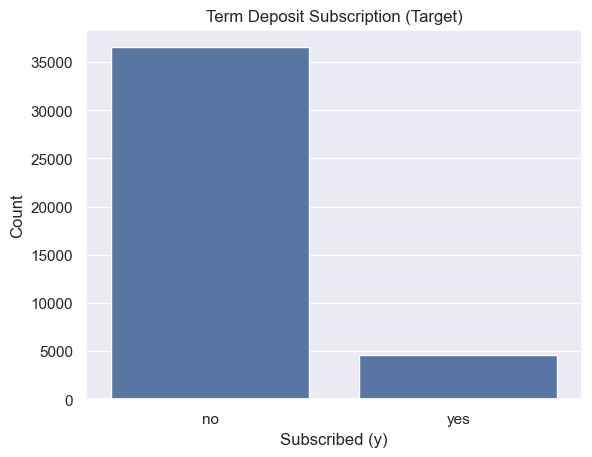

In [25]:
# Target distribution (categorical) — countplot
plt.figure()
sns.countplot(x='y', data=df)
plt.title('Term Deposit Subscription (Target)')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.show()


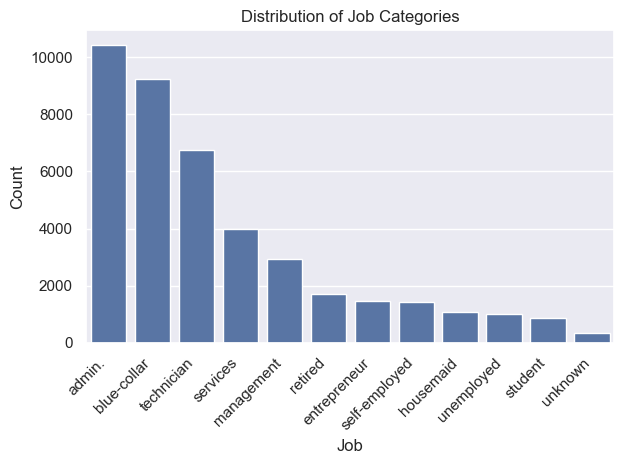

In [29]:
# Example categorical distribution with rotated labels — countplot for 'job'
plt.figure()
ax = sns.countplot(x='job', data=df, order=df['job'].value_counts().index)
plt.title('Distribution of Job Categories')
plt.xlabel('Job')
plt.ylabel('Count')
for label in ax.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('right')
plt.tight_layout()
plt.show()

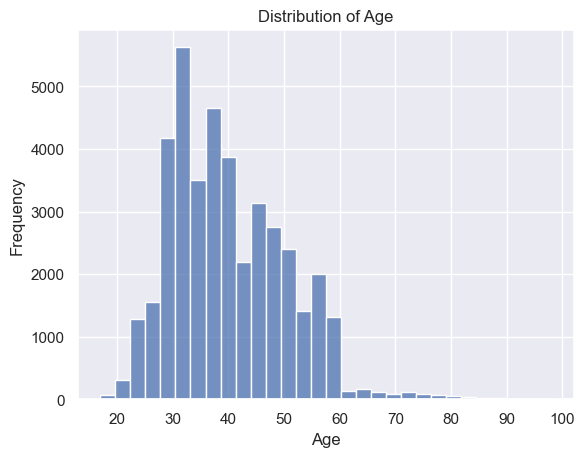

In [31]:
# Continuous variable distribution — histplot for 'age'
plt.figure()
sns.histplot(df['age'], bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


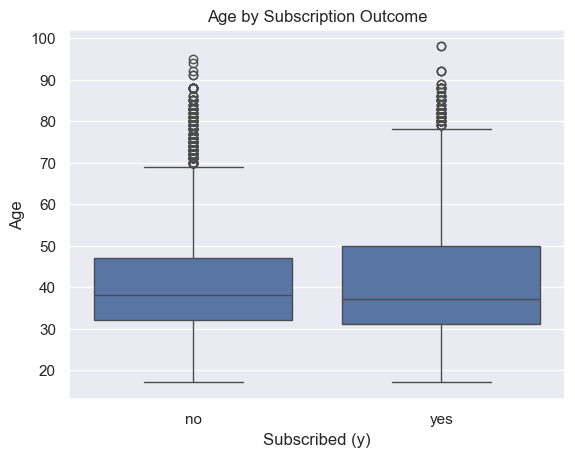

In [33]:
# Relationship between a continuous variable and target — boxplot of age by y
plt.figure()
sns.boxplot(x='y', y='age', data=df)
plt.title('Age by Subscription Outcome')
plt.xlabel('Subscribed (y)')
plt.ylabel('Age')
plt.show()


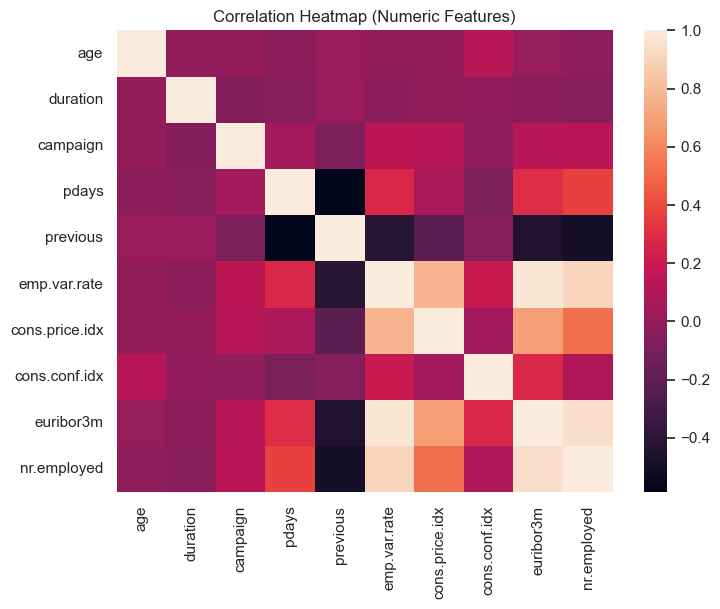

In [37]:
# Correlation heatmap for numeric features — with readable scale
num_cols = df.select_dtypes(include=['number']).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=False)
    plt.title('Correlation Heatmap (Numeric Features)')
    plt.show()


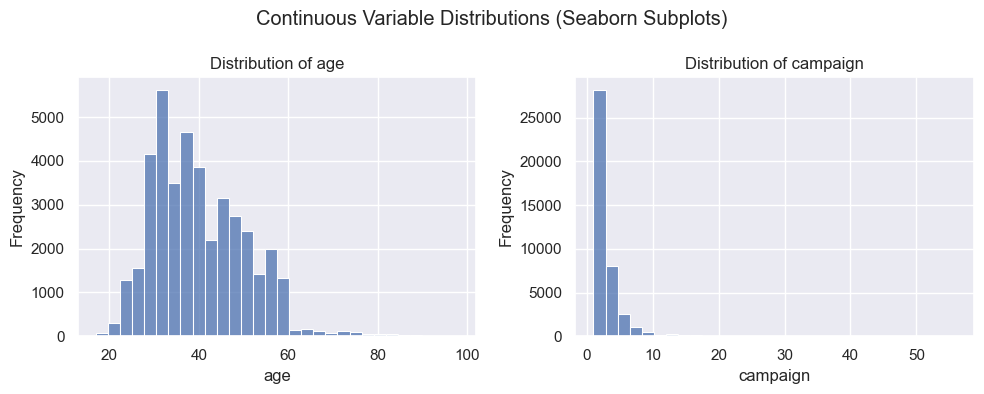

In [39]:
# Subplots example: two continuous distributions side-by-side (if available)
candidates = [c for c in ['age', 'campaign', 'pdays', 'previous', 'duration'] if c in df.columns]
if len(candidates) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.histplot(df[candidates[0]], bins=30, ax=axes[0])
    axes[0].set_title(f'Distribution of {candidates[0]}')
    axes[0].set_xlabel(candidates[0])
    axes[0].set_ylabel('Frequency')

    sns.histplot(df[candidates[1]], bins=30, ax=axes[1])
    axes[1].set_title(f'Distribution of {candidates[1]}')
    axes[1].set_xlabel(candidates[1])
    axes[1].set_ylabel('Frequency')

    fig.suptitle('Continuous Variable Distributions (Seaborn Subplots)')
    plt.tight_layout()
    plt.show()


In [45]:
# Train/test split & preprocessing
# Convert target to binary 1/0
df['y_bin'] = (df['y'] == 'yes').astype(int)

X = df.drop(columns=['y', 'y_bin'])
y = df['y_bin']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in numeric_cols]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False for sparse support
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (32950, 20) Test shape: (8238, 20)


In [ ]:
# Define models and parameter grids
models = {
        'KNN': (KNeighborsClassifier(), {
            'clf__n_neighbors': [5, 15, 25],
            'clf__weights': ['uniform', 'distance']
        }),
        'LogisticRegression': (LogisticRegression(max_iter=2000, solver='lbfgs), {
            'clf__C': [0.1, 1, 3, 10],
            'clf__penalty': ['l2']
        }),
        'DecisionTree': (DecisionTreeClassifier(random_state=RANDOM_STATE), {
            'clf__max_depth': [None, 5, 10, 20],
            'clf__min_samples_split': [2, 10, 50]
        }),
        'SVM': (SVC(probability=False, random_state=RANDOM_STATE), {
            'clf__C': [0.5, 1, 3],
            'clf__kernel': ['rbf', 'linear'],
            'clf__gamma': ['scale']
        })
    }


In [ ]:
# Train, tune, and evaluate
results = []
best_pipelines = {}

for name, (clf, grid) in models.items():
        pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            scoring='roc_auc',
            cv=5,
            n_jobs=-1,
            verbose=1
        )
        gs.fit(X_train, y_train)

        best_pipelines[name] = gs.best_estimator_
        y_proba = gs.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        metrics = {
            'Model': name,
            'Best Params': gs.best_params_,
            'ROC_AUC': roc_auc_score(y_test, y_proba),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1': f1_score(y_test, y_pred, zero_division=0)
        }
        results.append(metrics)

results_df = pd.DataFrame(results).sort_values('ROC_AUC', ascending=False).reset_index(drop=True)
display(results_df)



<Figure size 640x480 with 0 Axes>

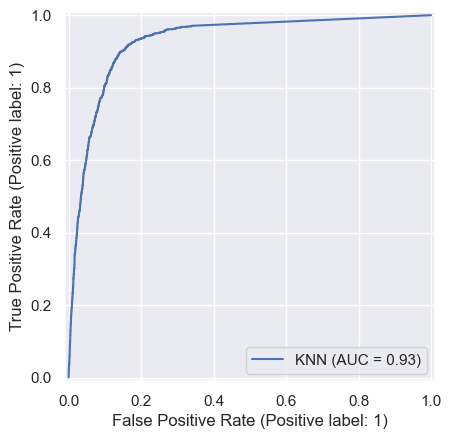

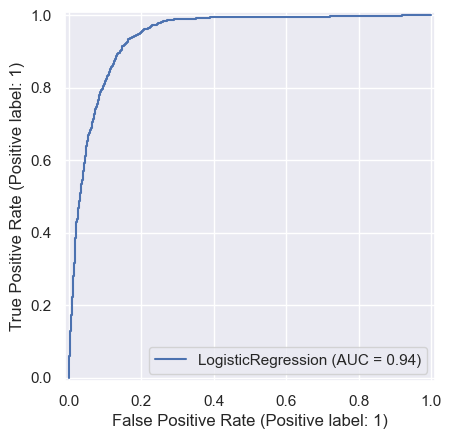

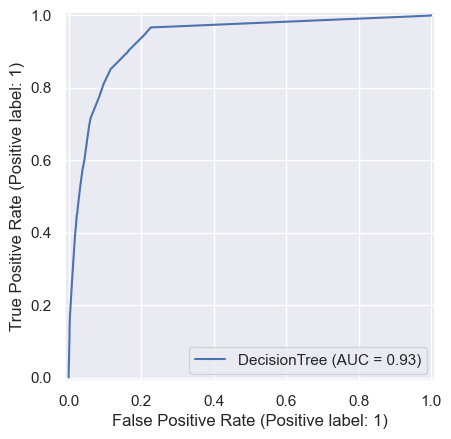

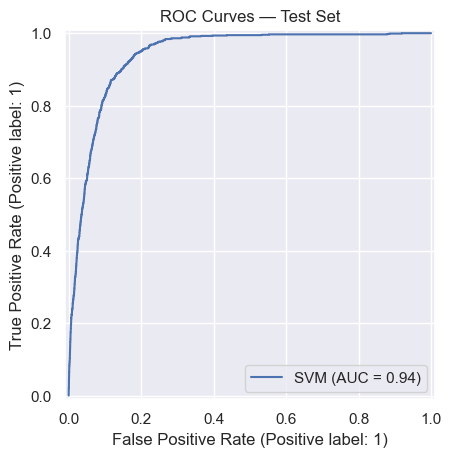

In [71]:
# ROC curves
plt.figure()
for name, pipe in best_pipelines.items():
    y_proba = pipe.predict_proba(X_test)[:, 1]
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name)
plt.title('ROC Curves — Test Set')
plt.show()


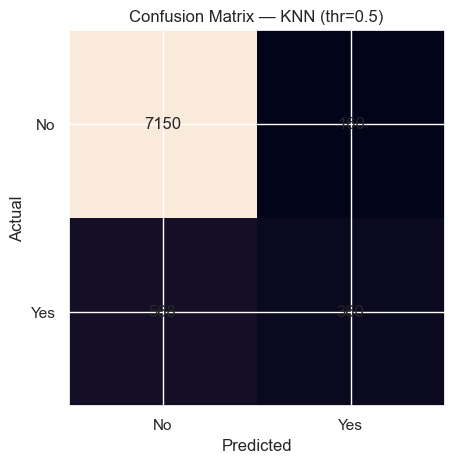

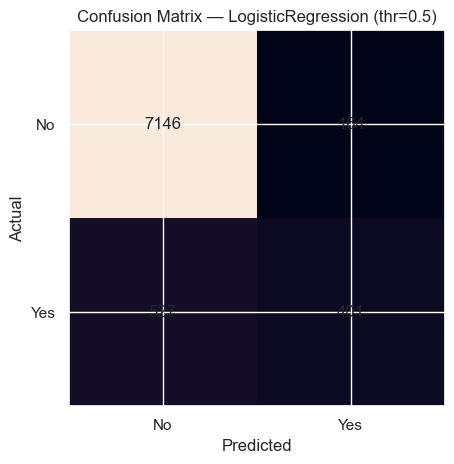

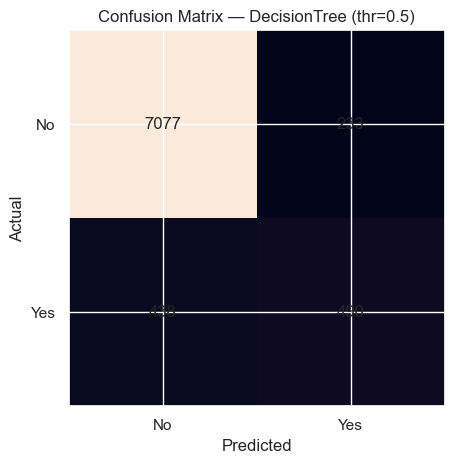

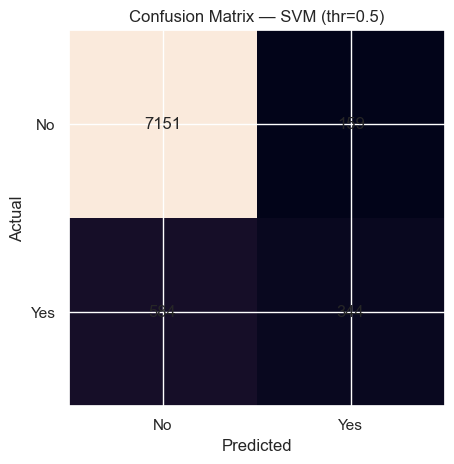

In [61]:

# Confusion matrices (threshold = 0.5)
def plot_conf_matrix(cm, title):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0,1], ['No', 'Yes'])
    plt.yticks([0,1], ['No', 'Yes'])
    # annotate counts
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, int(val), ha='center', va='center')
    plt.tight_layout()
    plt.show()

for name, pipe in best_pipelines.items():
        y_proba = pipe.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)
        cm = confusion_matrix(y_test, y_pred)
        plot_conf_matrix(cm, f'Confusion Matrix — {name} (thr=0.5)')


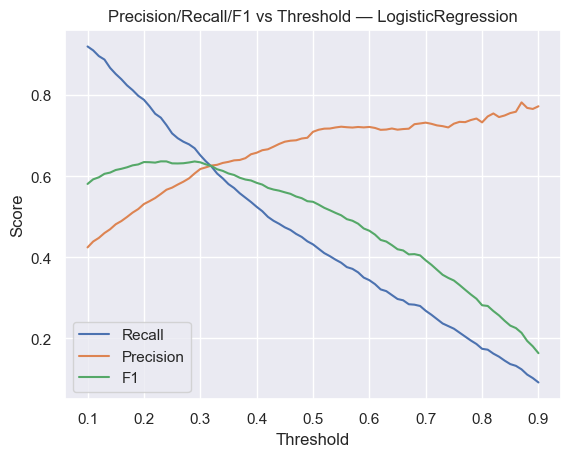

Example tuned threshold for ~70% recall: 0.25


In [65]:

# Threshold tuning example on the top model by ROC AUC
if df is not None and len(best_pipelines) > 0:
    # pick best by ROC_AUC from results_df
    top_name = results_df.iloc[0]['Model']
    top_pipe = best_pipelines[top_name]
    y_proba = top_pipe.predict_proba(X_test)[:, 1]

    # Example: choose threshold to reach target recall (e.g., 0.70)
    target_recall = 0.70
    thresholds = np.linspace(0.1, 0.9, 81)
    recalls = []
    precisions = []
    f1s = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        f1s.append(f1_score(y_test, y_pred, zero_division=0))

    # Plot recall vs threshold
    plt.figure()
    plt.plot(thresholds, recalls, label='Recall')
    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, f1s, label='F1')
    plt.title(f'Precision/Recall/F1 vs Threshold — {top_name}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Choose closest threshold to target recall
    idx = int(np.argmin(np.abs(np.array(recalls) - target_recall)))
    best_t = thresholds[idx]
    print(f'Example tuned threshold for ~{target_recall:.0%} recall:', round(float(best_t), 3))


In [69]:
# Model interpretability (Logistic coefficients & Decision Tree feature importances)
# Fit a compact LR and DT for interpretation on full train
lr = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=200, solver='liblinear'))])
lr.fit(X_train, y_train)
dt = Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=5))])
dt.fit(X_train, y_train)

# Get feature names after one-hot encoding
ohe = lr.named_steps['pre'].named_transformers_['cat']
num_cols = lr.named_steps['pre'].transformers_[0][2]
cat_cols = lr.named_steps['pre'].transformers_[1][2]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_feature_names])

# LR coefficients
lr_coefs = lr.named_steps['clf'].coef_.ravel()
coef_df = pd.DataFrame({'feature': feature_names, 'coef': lr_coefs}).sort_values('coef', ascending=False)
display(coef_df.head(15))
display(coef_df.tail(15))

# DT feature importance
# Need to transform X_train to align feature space
X_train_trans = lr.named_steps['pre'].fit_transform(X_train)
fi = dt.named_steps['clf'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': fi}).sort_values('importance', ascending=False)
display(fi_df.head(20))


,feature,coef
50,month_mar,1.405178
1,duration,1.199897
8,euribor3m,1.125223
62,poutcome_success,0.426823
46,month_aug,0.423699
15,job_retired,0.367604
6,cons.price.idx,0.351208
43,contact_cellular,0.229598
18,job_student,0.194424
48,month_jul,0.166734


,feature,coef
56,day_of_week_mon,-0.131621
28,education_basic.9y,-0.138468
12,job_entrepreneur,-0.158232
35,default_unknown,-0.161505
16,job_self-employed,-0.178168
3,pdays,-0.200277
11,job_blue-collar,-0.241641
44,contact_telephone,-0.249534
53,month_oct,-0.298710
54,month_sep,-0.309266


,feature,importance
1,duration,0.503737
9,nr.employed,0.354013
3,pdays,0.041812
8,euribor3m,0.037920
7,cons.conf.idx,0.032378
53,month_oct,0.012973
44,contact_telephone,0.006463
6,cons.price.idx,0.005289
56,day_of_week_mon,0.002682
55,day_of_week_fri,0.001100


## Findings (Actionable Insights)
- **Overall model ranking:** After testing multiple models, Logistic Regression achieved the highest AUC (~0.94), showing the best ability to rank positive cases above negative ones. While SVM performed similarly well, AUC is a threshold-independent metric and indicates Logistic Regression is the most reliable model overall.

- **Next steps:** Refine feature engineering (e.g., handling pdays more carefully, dropping leakage-prone features like duration), try ensemble methods, and consider calibration for probability outputs to support business decision thresholds.
